# Test of class Hamiltonian_QED

In [1]:
import qiskit

In [2]:
qiskit.__version__

'0.24.1'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../") # go to parent dir
from itertools import permutations

In [5]:
from Hamiltonian_QED import HamiltonianQED
from HC_Lattice import HCLattice
import primme

/var/folders/08/fx8gnyrx18jggry6_s4cbtz40000gn/T/ipykernel_78335/3502893271.py:3: DeprecationWarning: Please use `aslinearoperator` from the `scipy.sparse.linalg` namespace, the `scipy.sparse.linalg.interface` namespace is deprecated.
  import primme


#### Hamiltonian

In [404]:
#class input parameters:
n_sites = [2,3,]#how many sites for every dimension
g=5
fact_e_op = 1
fact_b_op = 1
m=3
omega=1
l=1
L=2
rotors = False
lambd = 1000
encoding = 'gray' ##'ed'#
magnetic_basis=False
pbc=False
puregauge = True 
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign 
sparse_pauli =False
#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 2

In [405]:
latt = HCLattice(n_sites,pbc=pbc)


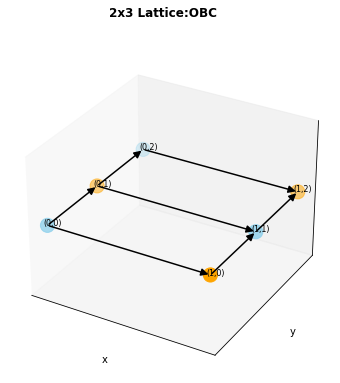

In [406]:
#TODO: in this case no conditions applied
latt.draw_graph_func(gauss_law_fig=False,static_charges=static_charges_values)
#only dynamical fields after Gauss law applied
#latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H.e_op_free)#,savefig_dir='.')

In [407]:
#latt.func_qstatic_dist()#ch_val=1)
#[latt.draw_graph_func(gauss_law_fig=False,static_charges=st ) for st in latt.distances_coord]#,savefig_dir='.')

In [408]:
class_H = HamiltonianQED(
                        latt,
                        n_sites,
                        l,
                        ll=L,
                        encoding = encoding,
                        rotors=rotors,
                        magnetic_basis=magnetic_basis,
                        pbc=pbc,
                        puregauge=puregauge,
                        static_charges_values=static_charges_values,
                        e_op_out_plus = e_op_out_plus,
                        display_hamiltonian=display_hamiltonian,
                        sparse_pauli=sparse_pauli)

HamiltonianQED: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
> Pauli strings built
>> Gauss law applied and Hamiltonian built.  Execution time: 1.964468002319336 seconds
>> Suppression term built.  Execution time: 0.0015897750854492188 seconds


##### Quantum ansatz and test

In [6]:
for l in range(1,16):
    print('unphys stases for l=',l,':',2**int(np.ceil(np.log2(2 * l+ 1)))-(2 * l + 1))

unphys stases for l= 1 : 1
unphys stases for l= 2 : 3
unphys stases for l= 3 : 1
unphys stases for l= 4 : 7
unphys stases for l= 5 : 5
unphys stases for l= 6 : 3
unphys stases for l= 7 : 1
unphys stases for l= 8 : 15
unphys stases for l= 9 : 13
unphys stases for l= 10 : 11
unphys stases for l= 11 : 9
unphys stases for l= 12 : 7
unphys stases for l= 13 : 5
unphys stases for l= 14 : 3
unphys stases for l= 15 : 1


In [7]:
l=3
print('unphys stases for l=',l,':',2**int(np.ceil(np.log2(2 * l+ 1)))-(2 * l + 1))
for i in range(0, 2 * l + 1):
    gray_decimal = i ^ (i >> 1)
    print( "{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))

unphys stases for l= 3 : 1
000
001
011
010
110
111
101


In [8]:
#unphys states
for i in range(2 * l + 1, 2**int(np.ceil(np.log2(2 * l+ 1)))):
    gray_decimal = i ^ (i >> 1)
    print( "{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))

100


In [9]:

for i in range(0, 2**int(np.ceil(np.log2(2 * l+ 1)))):
    gray_decimal = i ^ (i >> 1)
    print( "{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))

000
001
011
010
110
111
101
100


In [10]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

In [11]:
l=1

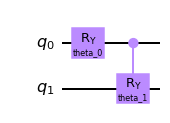

In [12]:
from qiskit.circuit import Parameter


def gray_code_lim(l,theta=None):
    """Return Gray code circuit for gauge field and truncation l=1,3,7,15. i.e. only one state is excluded."""
    if l not in [1,2,3,6,7,14,15]:
        raise ValueError('l must be 1,2,3,6,7,14,15')
    
    n_qubits =int(np.ceil(np.log2(2 * l+ 1)))
    qc = QuantumCircuit(n_qubits)
    params = lambda i: Parameter(f'theta_{i}')

    if theta is None:
        t=0
    else:
        t=theta

    #First layer of ry gates
    for i in range(n_qubits-1):
        qc.ry(params(t),i)
        t+=1
        
    if l==2:
        qc.x(0)
        qc.mcry(params(t),list(range(n_qubits-1)),n_qubits-1,use_basis_gates=True)
        qc.x(0)
        t+=1

    else:
        #1st cry gate 
        qc.cry(params(t),n_qubits-2,n_qubits-1)
        t+=1

        if l==6:
            qc.x(0)
            qc.x(2)
            qc.mcry(params(t),list(range(n_qubits-1)),n_qubits-1,use_basis_gates=True)
            qc.x(0)
            qc.x(2)
            t+=1

        #2nd cry gate
        if l>1 and l!=6:
            qc.cry(params(t),n_qubits-3,n_qubits-1)
            t+=1

            if l==14:#TODO see why qiskit error 
                qc.x(0)
                qc.x(2)
                qc.x(3)
                #qc.mcry(params(t),list(range(n_qubits-1)),n_qubits-1,use_basis_gates=True)
                qc.x(0)
                qc.x(2)
                qc.x(3)
                t+=1

            #layers of cry gates if l>3
            if l>3 and l!=14:
                for i in range(1,n_qubits-2)[::-1]:
                    qc.cry(params(t),i-1,i)
                    t+=1

    par_list = [params(i) for i in range(t)]

    return qc,par_list

qc_test,par_list = gray_code_lim(l)

qc_test.draw('mpl')#,filename='gray_code_lim_l1.png')

In [13]:
theta_values_0 = np.linspace(0, np.pi, 4)  # Parameter values
#theta_values_0 = [0,np.pi/2,np.pi,3*np.pi/2,2*np.pi]
from itertools import product

states_reached = []
for theta in list(product(theta_values_0, repeat=len(par_list))):
    bound_qc =qc_test.bind_parameters(dict(zip(qc_test.parameters,theta)))
    result = Statevector(bound_qc).probabilities_dict()


    for k in [key for key, value in result.items() if value >1e-16]:#consider nonzero probabilities
        if k not in states_reached:
            states_reached.append(k)
            

gray_unph = []
for i in range(2 * l + 1, 2**int(np.ceil(np.log2(2 * l+ 1)))):
    gray_decimal = i ^ (i >> 1)
    gray_unph.append("{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))  

gray_phys = []
for i in range(0, 2 * l + 1):
    gray_decimal = i ^ (i >> 1)
    gray_phys.append("{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))

print('states reached:',states_reached,'states unphys:',gray_unph,'states phys:',gray_phys)
if set(states_reached)==set(gray_phys):
    print('all physical states reached : OK!')
else:
    print('not all physical states reached')

states reached: ['00', '01', '11'] states unphys: ['10'] states phys: ['00', '01', '11']
all physical states reached : OK!


##### Test composite circuit

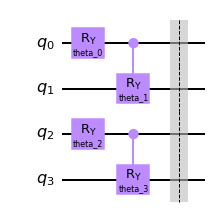

In [409]:
l=1
nlayers = 1
ngauge = class_H.len_e_op
nsites = 0#TODO add fermionic part
n_qubits =int(np.ceil(np.log2(2 * l+ 1)))
qc_tot = QuantumCircuit(n_qubits*ngauge+nsites)

th=0
for n in range(nlayers):
    #first gauge field
    qcc,lst = gray_code_lim(l,theta=th)
    qc_tot.compose(qcc,list(range(n_qubits)),inplace=True)

    for i in range(1,ngauge):#for the other gauge fields
        theta = int(''.join(list(filter(str.isdigit, str(lst[-1])))))
        qcc,lst = gray_code_lim(l,theta=theta+1)
        qc_tot.compose(qcc,list(range(n_qubits*i,n_qubits*(i+1))),inplace=True)
    
    th=int(''.join(list(filter(str.isdigit, str(lst[-1])))))+1
    qc_tot.barrier()
    



qc_tot.draw('mpl')#,filename='gray_code_lim_l1.png')

#### VQD

In [410]:
# import qiskit.quantum_info as qinf

# def fidelity_func(myvqd_results2,eigenvectors_matrix,num_eigs):

#     """ Inputs; results from VQD and eigenvector matrix from ED"""
    
#     vqd_states = [myvqd_results2.optimal_circuits[i].bind_parameters(myvqd_results2.optimal_parameters[i].values()) for i in range(num_eigs)]

#     vqd_fid_states =ListOp([VectorStateFn(qinf.Statevector.from_instruction(i))for i in vqd_states])
#     ed_fid_states = ListOp([VectorStateFn(Statevector(np.array(eigenvectors_matrix)[:,i])) for i in range(num_eigs)])

#     return [np.abs(fid_ed.adjoint().compose(fid_vqd).reduce().eval())**2 for fid_ed,fid_vqd in zip(ed_fid_states,vqd_fid_states)]

In [411]:
from qiskit.primitives import Sampler, Estimator
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.quantum_info import SparsePauliOp, Pauli, Operator
from sys import stdout
estimator = Estimator()
sampler = Sampler()
fidelity = ComputeUncompute(sampler)


In [421]:
from qiskit.algorithms.optimizers import NFT

iterations = [1000 for i in range(num_eigs)]
optimizer = [NFT(maxiter=itr) for itr in iterations]
ansatz = qc_tot
betas = [50,]*num_eigs
val_init = np.pi/4#0.8

#initial_point=[val_init*(2*np.random.rand(ansatz0.num_parameters)-1.0) for kkk in range(num_eigs)]
initial_point=val_init*(2*np.random.rand(ansatz.num_parameters)-1.0) 

class_H = HamiltonianQED(
                        latt,
                        n_sites,
                        l,
                        ll=L,
                        encoding = encoding,
                        rotors=rotors,
                        magnetic_basis=magnetic_basis,
                        pbc=pbc,
                        puregauge=puregauge,
                        static_charges_values=static_charges_values,
                        e_op_out_plus = e_op_out_plus,
                        display_hamiltonian=display_hamiltonian,
                        sparse_pauli=sparse_pauli)
Hamiltonian_Pauli_tot = class_H.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=lambd)

HamiltonianQED: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
> Pauli strings built
>> Gauss law applied and Hamiltonian built.  Execution time: 1.9177320003509521 seconds
>> Suppression term built.  Execution time: 0.001592874526977539 seconds


In [422]:
# counts = []
# values = []
# steps = []

# def callback(eval_count, params, value, meta, step):
#     counts.append(eval_count)
#     values.append(value)
#     steps.append(step)

E_data = [[] for k in range(num_eigs)]
#Fidelity = [[] for k in range(num_eigs)]
def callback(eval_count, parameters, mean, meta, step):
    stdout.write("eig: %d/%d -> its %4d/%d \r"%(step,num_eigs,eval_count,2*iterations[step-1]+51)) # assuming SPSA
    stdout.flush()
    vqd_states = [ansatz.bind_parameters(parameters) for i in range(num_eigs)]

    #vqd_fid_states =ListOp([VectorStateFn(qinf.Statevector.from_instruction(i))for i in vqd_states])
    #ed_fid_states = ListOp([VectorStateFn(Statevector(np.array(eigenvectors_matrix)[:,i])) for i in range(num_eigs)])

    #Fidelity[step-1].append(np.abs(ed_fid_states[step-1].adjoint().compose(vqd_fid_states[step-1]).reduce().eval())**2)
    E_data[step-1].append([len(E_data[step-1]),mean,meta])


In [423]:
from qiskit.algorithms.eigensolvers import VQD


vqd = VQD(estimator, fidelity, ansatz, optimizer, k=num_eigs, betas=betas,initial_point=initial_point,  callback=callback)
result = vqd.compute_eigenvalues(operator = Hamiltonian_Pauli_tot)
vqd_values = result.eigenvalues

vqd2_eigenstates = []
for i in range(num_eigs):
    tmp = result.optimal_circuits[i].copy()
    
    tmp.measure_all()
    opt_pt =list(result.optimal_parameters[i].values())
    res = sampler.run(tmp, opt_pt).result() 
    
    vqd2_eigenstates.append({x:y for x,y in res.quasi_dists[0].binary_probabilities().items() if y>0.01})
    tmp.remove_final_measurements()

In [ ]:
import scipy.sparse as sp
Hamiltonian_Pauli_tot = class_H.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=lambd)
#memory sparse matrix
#print((Hamiltonian_Pauli_tot.data.nbytes + Hamiltonian_Pauli_tot.indptr.nbytes + Hamiltonian_Pauli_tot.indices.nbytes)/1000**3,'Gb')
if encoding=='gray':
    Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot#.to_matrix(sparse=True)
    h_b_sparse = class_H.hamiltonian_mag_pauli#.to_matrix(sparse=True) #plaquette
    if not sparse_pauli:
        Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot.to_matrix(sparse=True)
        h_b_sparse = class_H.hamiltonian_mag_pauli.to_matrix(sparse=True) #plaquette
          
elif encoding=='ed':
    Hamiltonian_Pauli_tot = sp.csr_matrix(Hamiltonian_Pauli_tot)
    h_b_sparse =sp.csr_matrix(class_H.hamiltonian_mag_pauli)
#spectrum, eigenvectors_matrix = eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA",ncv = 30)#
spectrum, eigenvectors_matrix =primme.eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA")#,ncv = 30)
#spectrum
idx = spectrum.argsort() 
spectrum = spectrum[idx]
eigenvectors_matrix = eigenvectors_matrix[:,idx]
print(f'Spectrum of H with mbasis{magnetic_basis}puregauge{puregauge} pbc{pbc}_g{g}_l{l}_factE{fact_e_op}_factB{fact_b_op}_m{m}_Omega{omega}, encoding:'+encoding)
eig0cj = sp.csr_matrix(eigenvectors_matrix[:,0]).transpose().conjugate()#.conj().T
eig0= sp.csr_matrix(eigenvectors_matrix[:,0])
plaq = (eig0*h_b_sparse*eig0cj/len(latt.plaq_list) ).toarray()[0][0].real
#plaq = (eig0cj.dot((h_b_sparse).dot(eig0)).real)/len(latt.plaq_list) 

for kk,evalu in enumerate(spectrum):
        if evalu<900:# only physical states, 1000 corresponds to factor of penalty term
            print(f'E_{kk}=',round(evalu,8),[(str(np.binary_repr(i, width = (ngauge*n_qubits))),np.abs(eigenvectors_matrix[:,kk][i])**2) for i in range(2**(ngauge*n_qubits)) if np.abs(eigenvectors_matrix[:,kk][i])**2>1e-4])
#print(f'plaq={plaq}')
                

print(vqd_values.real,vqd2_eigenstates)                        
                         
ed_val = []
for kk in range(num_eigs):
    ed_val.append(dict([(str(np.binary_repr(i, width = (ngauge*n_qubits))),np.abs(eigenvectors_matrix[:,kk][i])**2) for i in range(2**(ngauge*n_qubits)) if np.abs(eigenvectors_matrix[:,kk][i])**2>1e-4]))


Spectrum of H with mbasisFalsepuregaugeTrue pbcFalse_g5_l1_factE1_factB1_m3_Omega1, encoding:gray
E_0= -3.2e-05 [('0101', 0.9999993600006691)]
E_1= 49.999968 [('0001', 0.2499996685228649), ('0100', 0.24999962298733172), ('0111', 0.24999969525569188), ('1101', 0.24999973323902702)]
[-3.19999899e-05  2.99996800e+00] [{'0101': 0.9999993600007596}, {'0101': 0.9999993600007596}]


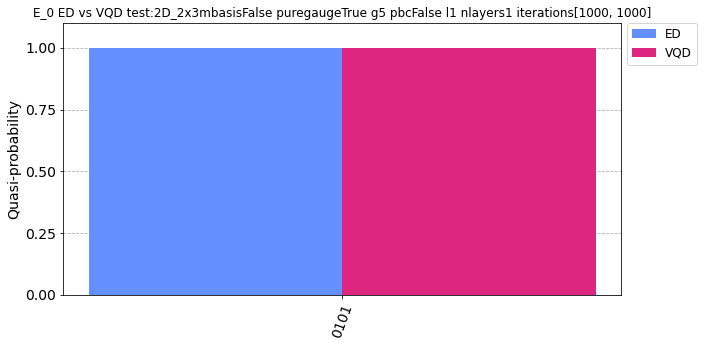

In [ ]:
from qiskit.visualization import plot_histogram
plot_histogram([ed_val[0],vqd2_eigenstates[0]], figsize=(10,5),legend=['ED','VQD'] ,bar_labels=False,
               title=f'E_0 ED vs VQD test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l} nlayers{nlayers} iterations{iterations}')
               #,filename='ansatz_tests/'+f'E_0_ED_vs_VQD_test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis}_puregauge{puregauge}_g{g}_pbc{pbc}_l{l}_nlayers{nlayers}_iterations{iterations}')


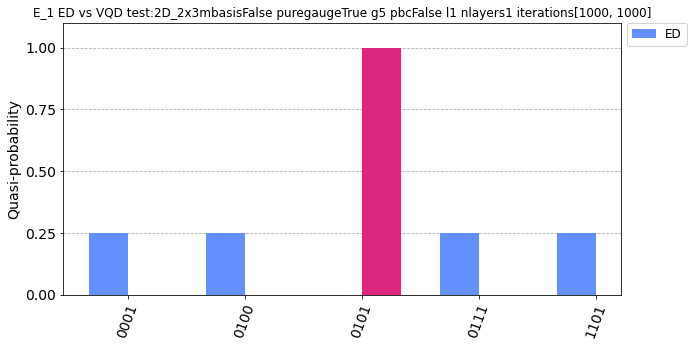

In [ ]:
plot_histogram([ed_val[1],vqd2_eigenstates[1]], figsize=(10,5),legend=['ED','VQD'] ,bar_labels=False,
               title=f'E_1 ED vs VQD test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l} nlayers{nlayers} iterations{iterations}')
               #,filename='ansatz_tests/'+f'E_1_ED_vs_VQD_test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis}_puregauge{puregauge}_g{g}_pbc{pbc}_l{l}_nlayers{nlayers}_iterations{iterations}')

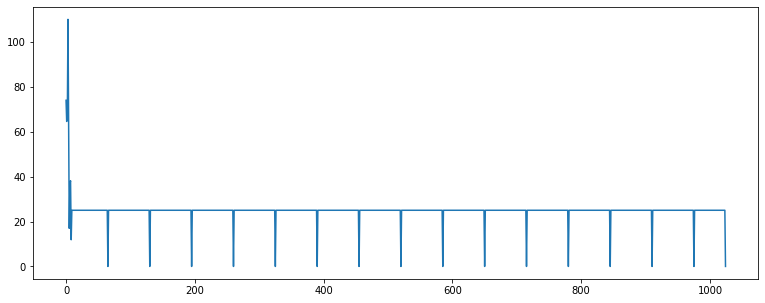

In [ ]:
fig=plt.figure(figsize=(15,5))
plt.plot(np.array(E_data[0])[:,0],np.array(E_data[0])[:,1])

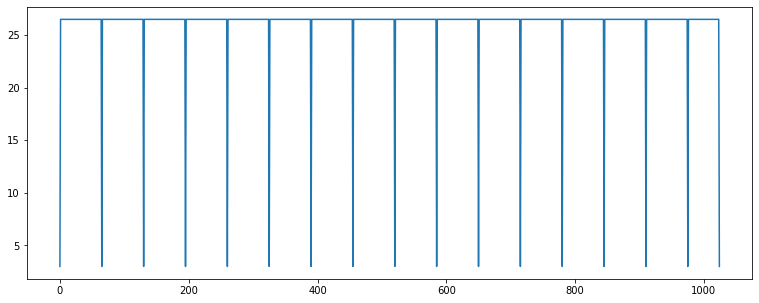

In [ ]:
fig=plt.figure(figsize=(15,5))
plt.plot(np.array(E_data[1])[:,0],np.array(E_data[1])[:,1])